# Chapter 10: DL - Recurrent Neural Networks

# A. Sentiment analysis 


Here we fit a simple LSTM RNN for sentiment analysis with the *IMDb* movie-review data (part of the *keras* library).

In [39]:
library(keras)

In [2]:
max_features <- 10000

imdb <- dataset_imdb(num_words = max_features)

In [3]:
#unpacking list of lists
c(c(x_train, y_train), c(x_test, y_test)) %<-% imdb

In [4]:
word_index <- dataset_imdb_word_index()

In [5]:
#create a function, decode review(), 
#that provides a simple interface to the dictionary.
decode_review <- function(text, word_index) {
                word <- names(word_index)
                idx <- unlist(word_index, use.names = FALSE)
                word <- c("<PAD>", "<START>", "<UNK>", "<UNUSED>", word)
                idx <- c(0:3, idx + 3)
                words <- word[match(text, idx, 2)]
                paste(words, collapse = " ")}

In [6]:
x_train[[1]][1:25]

[1]    1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941    4
[16]  173   36  256    5   25  100   43  838  112   50

In [7]:
decode_review(x_train[[1]][1:25], word_index)

[1] "<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there"

In [8]:
wc <- sapply(x_train, length)
median(wc)

[1] 178

In [10]:
#over 91% of the documents have fewer than 500 words.
sum(wc <= 500) / length(wc)

[1] 0.91568

In [11]:
#RNN requires all the document sequences to have the same length.  
#use the last L = 500 words, 
#and pad the beginning of the shorter ones with blanks
maxlen <- 500
x_train <- pad_sequences(x_train, maxlen = maxlen)
x_test <- pad_sequences(x_test, maxlen = maxlen)

In [12]:
dim(x_train)

[1] 25000   500

In [14]:
#RNN model
model <- keras_model_sequential() %>%
    layer_embedding(input_dim = 10000, output_dim = 32) %>%
    layer_lstm(units = 32) %>%
    layer_dense(units = 1, activation = "sigmoid")

In [15]:
model

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 embedding (Embedding)              (None, None, 32)                320000      
 lstm (LSTM)                        (None, 32)                      8320        
 dense (Dense)                      (None, 1)                       33          
Total params: 328353 (1.25 MB)
Trainable params: 328353 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________

The first layer of the RNN is an embedding layer of size 32, which will be learned during training. This layer one-hot encodes each document as a matrix of dimension 500 × 10, 000, and then maps these 10, 000 dimensions down to 32.

The second layer is an LSTM with 32 units, and the output layer is a single sigmoid for the binary classification task

In [16]:
model %>% compile(optimizer = "rmsprop",
loss = "binary_crossentropy", metrics = c("acc"))

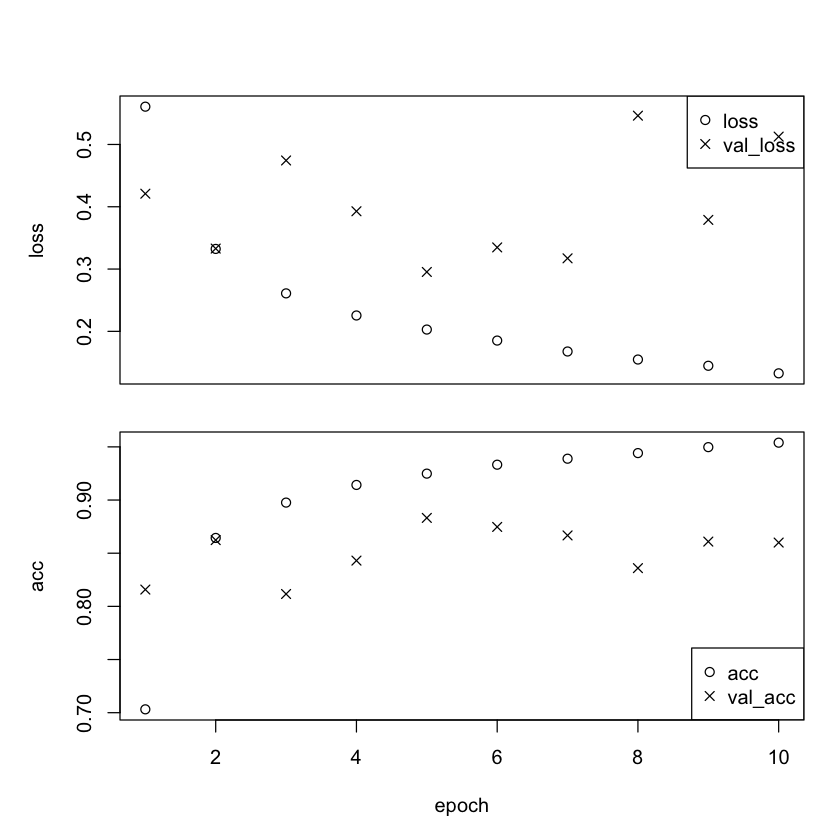

In [17]:
history <- model %>% fit(x_train, y_train, epochs = 10, batch_size = 128, validation_data = list(x_test, y_test))
plot(history)


In [22]:
predy <- predict(model, x_test) >0.5

In [23]:
mean(abs(y_test == as.numeric(predy)))

[1] 0.86

# B. Time Series Prediction

In [1]:
library(keras)

In [2]:
library(ISLR2)
xdata <- data.matrix(
NYSE[, c("DJ_return", "log_volume","log_volatility")])

In [3]:
head(NYSE)

,date,day_of_week,DJ_return,log_volume,log_volatility,train
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
1,1962-12-03,mon,-0.004461,0.032573,-13.12740,TRUE
2,1962-12-04,tues,0.007813,0.346202,-11.74930,TRUE
3,1962-12-05,wed,0.003845,0.525306,-11.66561,TRUE
4,1962-12-06,thur,-0.003462,0.210182,-11.62677,TRUE
5,1962-12-07,fri,0.000568,0.044187,-11.72813,TRUE
6,1962-12-10,mon,-0.010824,0.133246,-10.87253,TRUE


In [4]:
head(xdata)

DJ_return,log_volume,log_volatility
-0.004461,0.032573,-13.12740
0.007813,0.346202,-11.74930
0.003845,0.525306,-11.66561
-0.003462,0.210182,-11.62677
0.000568,0.044187,-11.72813
-0.010824,0.133246,-10.87253


In [5]:
#The variable istrain contains a TRUE for 
#each year that is in the training set, 
#and a FALSE for each year in the test set.
istrain <- NYSE[, "train"]
xdata <- scale(xdata)

## Create an autoregressive dataframe

We first write functions to create lagged versions of the three time series. We start with a function that takes as input a data matrix and a lag L, and returns a lagged version of the matrix. 

In [6]:
lagm <- function(x, k = 1) {
        n <- nrow(x)
        pad <- matrix(NA, k, ncol(x))
        rbind(pad, x[1:(n - k), ]) }

We now use this function to create a data frame with all the required lags, as well as the response variable.

In [7]:
#autoregression dataframe
arframe <- data.frame(log_volume = xdata[, "log_volume"], 
                        L1 = lagm(xdata, 1), L2 = lagm(xdata, 2),
                        L3 = lagm(xdata, 3), L4 = lagm(xdata, 4),
                        L5 = lagm(xdata, 5))


In [8]:
head(arframe)

,log_volume,L1.DJ_return,L1.log_volume,L1.log_volatility,L2.DJ_return,L2.log_volume,L2.log_volatility,L3.DJ_return,L3.log_volume,L3.log_volatility,L4.DJ_return,L4.log_volume,L4.log_volatility,L5.DJ_return,L5.log_volume,L5.log_volatility
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.1750605,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1.5171653,-0.54977791,0.1750605,-4.356718,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,2.2836006,0.90512515,1.5171653,-2.528849,-0.5497779,0.1750605,-4.356718,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,0.9350983,0.43477682,2.2836006,-2.417837,0.9051251,1.5171653,-2.528849,-0.5497779,0.1750605,-4.356718,NA,NA,NA,NA,NA,NA
5,0.2247600,-0.43136108,0.9350983,-2.366325,0.4347768,2.2836006,-2.417837,0.9051251,1.5171653,-2.528849,-0.5497779,0.1750605,-4.356718,NA,NA,NA
6,0.6058680,0.04633644,0.2247600,-2.500763,-0.4313611,0.9350983,-2.366325,0.4347768,2.2836006,-2.417837,0.9051251,1.5171653,-2.528849,-0.5497779,0.1750605,-4.356718


## Fit an autoregressive model

If we look at the first five rows of this frame, we will see some missing values in the lagged variables (due to the construction above). We remove these rows, and adjust istrain accordingly.

In [9]:
arframe <- arframe[-(1:5), ] 
istrain <- istrain[-(1:5)]

We now fit the linear AR model to the training data using lm(), and predict on the test data.

In [10]:
arfit <- lm(log_volume ~ ., data = arframe[istrain, ])
arpred <- predict(arfit, arframe[!istrain, ])
V0 <- var(arframe[!istrain, "log_volume"])
1 - mean((arpred - arframe[!istrain, "log_volume"])^2) / V0

[1] 0.413223

We refit this model, including the factor variable day of week.

In [12]:
arframed <-
data.frame(day = NYSE[-(1:5), "day_of_week"], arframe)
arfitd <- lm(log_volume ~ ., data = arframed[istrain, ])
arpredd <- predict(arfitd, arframed[!istrain, ])
1 - mean((arpredd - arframe[!istrain, "log_volume"])^2) / V0

[1] 0.4598616

## Fit an RNN 

To fit the RNN, we need to reshape these data, since it expects a sequence of $L = 5$ feature vectors $X = {X_l}^L_1$ for each observation. These are lagged versions of the time series going back $L$ time points.

In [13]:
n <- nrow(arframe)
xrnn <- data.matrix(arframe[, -1]) 
xrnn <- array(xrnn, c(n, 3, 5))
xrnn <- xrnn[,, 5:1]
xrnn <- aperm(xrnn, c(1, 3, 2))
dim(xrnn)

[1] 6046    5    3

In [14]:
model <- keras_model_sequential() %>%
        layer_simple_rnn(units = 12,input_shape = list(5, 3),
                        dropout = 0.1, recurrent_dropout = 0.1) %>%
        layer_dense(units = 1)


In [15]:
model %>% compile(optimizer = optimizer_rmsprop(), loss = "mse")

In [16]:
history <- model %>% fit(xrnn[istrain,, ], arframe[istrain, "log_volume"], 
                        batch_size = 64, epochs = 200,
                        validation_data = list(xrnn[!istrain,, ], arframe[!istrain, "log_volume"])
                        )

In [17]:
history


Final epoch (plot to see history):
    loss: 0.4269
val_loss: 0.626 

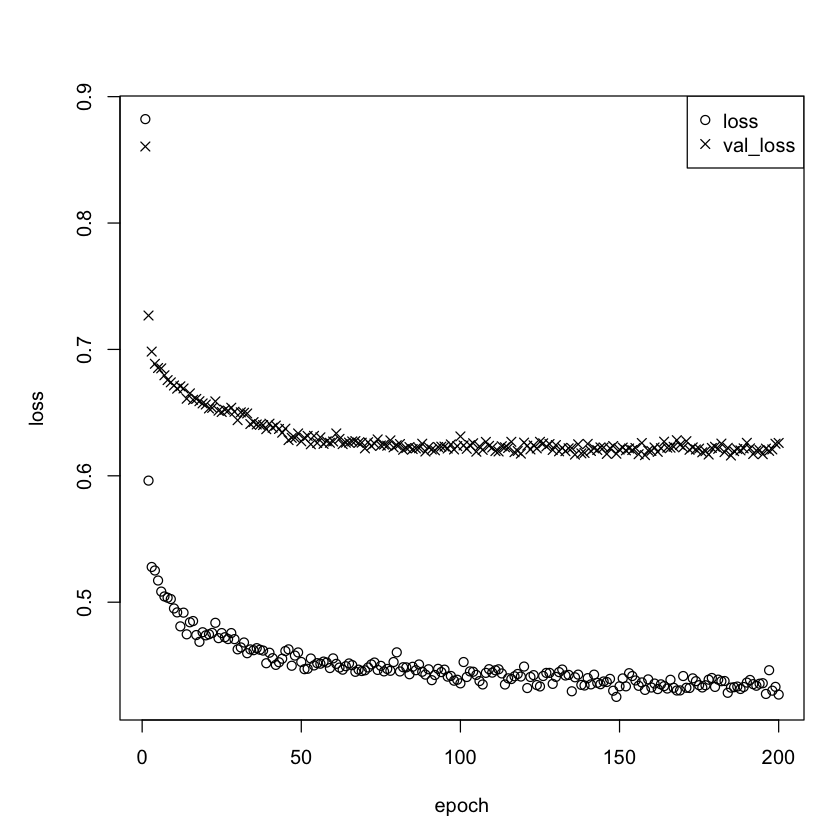

In [18]:
plot(history)

In [19]:
kpred <- predict(model, xrnn[!istrain,, ])
1 - mean((kpred - arframe[!istrain, "log_volume"])^2) / V0

[1] 0.4061207


# References

Chapter 10, **An Introduction to Statistical Learning with Applications in R**, Gareth James, Daniela Witten, Trevor Hastie, and Robert Tibshirani.
